<a href="https://colab.research.google.com/github/yeon524/TEAM_PROJECT/blob/main/%EB%AC%BC%EB%A5%98_%EC%84%BC%ED%84%B0_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyscipopt ortools pandas


In [ ]:
import math
import pandas as pd
from pyscipopt import Model, quicksum
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# =========================
# 0. 데이터 불러오기
# =========================
cust_df = pd.read_csv("Customer.csv")              # X, Y, DEMAND
dc_df   = pd.read_csv("DistributionCenter.csv")    # X, Y, CAPACITY, COST(또는 FIXED_COST)
truck_df = pd.read_csv("Truck.csv")

TRUCK_CAPACITY = int(truck_df.loc[0, "CAPACITY"])

# 필요하면 컬럼 이름 확인해보고 맞춰줘
# print(cust_df.head())
# print(dc_df.head())
# print(truck_df.head())

def euclidean_xy(x1, y1, x2, y2):
    return math.hypot(x1 - x2, y1 - y2)


# =========================
# 1. 1단계: SCIP + CFLP
# =========================
def solve_cflp_scip(case: int,
                    balance_ratio=(0.6, 1.4),
                    min_center_demand=None,
                    time_limit=60.0):
    """
    case: 0,1,2,3
    Case 0: 추가 제약 없음
    Case 1: 균형 배분 제약만
    Case 2: 최소 수요 제약만
    Case 3: 둘 다
    """
    num_cust = len(cust_df)
    num_dc = len(dc_df)
    I = range(num_cust)
    J = range(num_dc)

    demands = cust_df["DEMAND"].to_numpy()
    TOTAL_DEMAND = demands.sum()

    if min_center_demand is None:
        # 대충 전체수요 / (2 * 센터수) 정도로 기본값
        min_center_demand = TOTAL_DEMAND / (2 * num_dc)

    # 운송비 근사: 거리 × 수요
    cost_ij = {}
    for i in I:
        xi, yi, di = cust_df.loc[i, ["X", "Y", "DEMAND"]]
        for j in J:
            xj, yj = dc_df.loc[j, ["X", "Y"]]
            dist = euclidean_xy(xi, yi, xj, yj)
            cost_ij[(i, j)] = dist * di

    model = Model("CFLP")
    model.hideOutput()

    # --- 변수 ---
    y = {j: model.addVar(vtype="B", name=f"y_{j}") for j in J}                  # 센터 개설 여부
    x = {(i, j): model.addVar(vtype="B", name=f"x_{i}_{j}") for i in I for j in J}  # 고객 배정

    # --- 목적함수: 센터 고정비 + 운송비 ---
    # 고정비 컬럼명이 COST가 아니면 여기만 바꿔줘 (예: FIXED_COST)
    model.setObjective(
        quicksum(dc_df.loc[j, "COST"] * y[j] for j in J) +
        quicksum(cost_ij[(i, j)] * x[(i, j)] for i in I for j in J),
        "minimize"
    )

    # --- 제약 1: 각 고객은 정확히 1개 센터에 배정 ---
    for i in I:
        model.addCons(quicksum(x[(i, j)] for j in J) == 1, name=f"assign_{i}")

    # --- 제약 2: 센터 용량 ---
    for j in J:
        cap_j = dc_df.loc[j, "CAPACITY"]
        model.addCons(
            quicksum(demands[i] * x[(i, j)] for i in I) <= cap_j * y[j],
            name=f"capacity_{j}"
        )

    # --- Case별 추가 제약 ---

    min_ratio, max_ratio = balance_ratio

    # Case 1 & 3: 균형 배분 제약
    if case in (1, 3):
        avg_demand_per_dc = TOTAL_DEMAND / num_dc
        for j in J:
            load_j = quicksum(demands[i] * x[(i, j)] for i in I)
            model.addCons(
                load_j >= min_ratio * avg_demand_per_dc * y[j],
                name=f"balance_min_{j}"
            )
            model.addCons(
                load_j <= max_ratio * avg_demand_per_dc * y[j],
                name=f"balance_max_{j}"
            )

    # Case 2 & 3: 최소 수요 제약
    if case in (2, 3):
        for j in J:
            load_j = quicksum(demands[i] * x[(i, j)] for i in I)
            model.addCons(
                load_j >= min_center_demand * y[j],
                name=f"minload_{j}"
            )

    # 시간 제한
    model.setRealParam("limits/time", float(time_limit))
    model.optimize()

    open_centers = [j for j in J if model.getVal(y[j]) > 0.5]
    assignment = {}
    for i in I:
        for j in J:
            if model.getVal(x[(i, j)]) > 0.5:
                assignment[i] = j
                break

    obj_value = model.getObjVal()
    return open_centers, assignment, obj_value


# =========================
# 2. 2단계: OR-Tools VRP
#    mode="ortools" → GLS
#    mode="tabu"    → TABU_SEARCH
# =========================
def solve_vrp_for_center(center_idx, cust_indices, mode="ortools",
                         time_limit_sec=10):
    """
    center_idx: DistributionCenter index
    cust_indices: 이 센터가 담당하는 Customer index 리스트
    mode: "ortools" (GLS) or "tabu"
    """
    if len(cust_indices) == 0:
        return 0.0

    # 노드 0 = depot, 1..N = 고객
    depot = dc_df.loc[center_idx]
    nodes = [(depot.X, depot.Y)]
    demands = [0]

    for i in cust_indices:
        row = cust_df.loc[i]
        nodes.append((row.X, row.Y))
        demands.append(int(row.DEMAND))

    n = len(nodes)

    # 거리행렬 (정수)
    dist = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            x1, y1 = nodes[i]
            x2, y2 = nodes[j]
            dist[i][j] = int(euclidean_xy(x1, y1, x2, y2) * 1000)

    # 차량 대수: 대략적으로 (총수요 / 차량용량) 만큼, 최소 1대
    total_demand = sum(demands)
    num_vehicles = max(1, math.ceil(total_demand / TRUCK_CAPACITY))

    manager = pywrapcp.RoutingIndexManager(n, num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return dist[f][t]

    transit_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    def demand_callback(from_idx):
        node = manager.IndexToNode(from_idx)
        return demands[node]

    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx,
        0,
        [TRUCK_CAPACITY] * num_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.time_limit.FromSeconds(time_limit_sec)
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    if mode == "ortools":
        search_params.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
        )
    elif mode == "tabu":
        search_params.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH
        )
    else:
        raise ValueError("mode must be 'ortools' or 'tabu'")

    solution = routing.SolveWithParameters(search_params)
    if solution is None:
        return float("inf")

    total_cost = 0
    for v in range(num_vehicles):
        idx = routing.Start(v)
        while not routing.IsEnd(idx):
            nxt = solution.Value(routing.NextVar(idx))
            total_cost += routing.GetArcCostForVehicle(idx, nxt, v)
            idx = nxt

    return total_cost / 1000.0  # 원래 거리 단위로 환산


# =========================
# 3. 전체 파이프라인: 1단계 + 2단계
# =========================
def run_pipeline(case: int, mode: str):
    """
    case: 0,1,2,3
    mode: "ortools" (GLS) or "tabu" (Tabu Search)
    """
    # 1단계: 입지 결정 (SCIP + CFLP)
    open_centers, assignment, cflp_cost = solve_cflp_scip(case)

    # 센터별 고객 리스트
    center_to_customers = {j: [] for j in open_centers}
    for i, j in assignment.items():
        if j in center_to_customers:
            center_to_customers[j].append(i)

    # 2단계: 각 센터에 대해 VRP (OR-Tools / Tabu)
    vrp_cost = 0.0
    for j in open_centers:
        vrp_cost += solve_vrp_for_center(j, center_to_customers[j], mode=mode)

    total_cost = cflp_cost + vrp_cost

    return {
        "case": case,
        "mode": mode,
        "open_centers": open_centers,
        "num_centers": len(open_centers),
        "cflp_cost": cflp_cost,
        "vrp_cost": vrp_cost,
        "total_cost": total_cost,
    }


# =========================
# 4. 8개 조합 (Case 0~3 × mode 2개) 실행
# =========================
import math

results = []
for case in [0, 1, 2, 3]:
    for mode in ["ortools", "tabu"]:
        print(f"\n=== Running Case {case}, mode={mode} ===")
        res = run_pipeline(case, mode)
        results.append(res)
        print(
            f"open_centers={res['open_centers']} "
            f"(#{res['num_centers']}), "
            f"CFLP={res['cflp_cost']:.2f}, "
            f"VRP={res['vrp_cost']:.2f}, "
            f"TOTAL={res['total_cost']:.2f}"
        )

print("\n=== SUMMARY ===")
for r in results:
    print(
        f"Case {r['case']}, mode={r['mode']}: "
        f"centers={r['num_centers']}, open={r['open_centers']}, "
        f"TOTAL={r['total_cost']:.2f} "
        f"(CFLP={r['cflp_cost']:.2f}, VRP={r['vrp_cost']:.2f})"
    )

best = min(results, key=lambda x: x["total_cost"])
print("\n=== BEST CONFIG (최소 총비용) ===")
print(
    f"Case {best['case']}, mode={best['mode']}, "
    f"open_centers={best['open_centers']} (#{best['num_centers']}), "
    f"TOTAL={best['total_cost']:.2f}, "
    f"CFLP={best['cflp_cost']:.2f}, VRP={best['vrp_cost']:.2f}"
)



=== Running Case 0, mode=ortools ===
open_centers=[0, 1, 2, 3, 4] (#5), CFLP=14161.70, VRP=569.70, TOTAL=14731.40

=== Running Case 0, mode=tabu ===
open_centers=[0, 1, 2, 3, 4] (#5), CFLP=14161.70, VRP=569.70, TOTAL=14731.40

=== Running Case 1, mode=ortools ===
open_centers=[0, 1, 2, 3, 4] (#5), CFLP=14727.79, VRP=615.41, TOTAL=15343.20

=== Running Case 1, mode=tabu ===
open_centers=[0, 1, 2, 3, 4] (#5), CFLP=14727.79, VRP=615.41, TOTAL=15343.20

=== Running Case 2, mode=ortools ===
open_centers=[0, 1, 2, 3, 4] (#5), CFLP=14229.62, VRP=607.96, TOTAL=14837.58

=== Running Case 2, mode=tabu ===
open_centers=[0, 1, 2, 3, 4] (#5), CFLP=14229.62, VRP=607.96, TOTAL=14837.58

=== Running Case 3, mode=ortools ===
open_centers=[0, 1, 2, 3, 4] (#5), CFLP=14727.79, VRP=615.41, TOTAL=15343.20

=== Running Case 3, mode=tabu ===
open_centers=[0, 1, 2, 3, 4] (#5), CFLP=14727.79, VRP=615.41, TOTAL=15343.20

=== SUMMARY ===
Case 0, mode=ortools: centers=5, open=[0, 1, 2, 3, 4], TOTAL=14731.40 (CFLP

In [ ]:
import math
import pandas as pd
from pyscipopt import Model, quicksum
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# =========================
# 0. CSV 불러오기
# =========================
cust_df = pd.read_csv("Customer.csv")              # 예: X, Y, DEMAND
dc_df   = pd.read_csv("DistributionCenter.csv")    # 예: X, Y, CAPACITY, COST
truck_df = pd.read_csv("Truck.csv")

TRUCK_CAPACITY = int(truck_df.loc[0, "CAPACITY"])  # 예: 160

def euclidean_xy(x1, y1, x2, y2):
    return math.hypot(x1 - x2, y1 - y2)


# =========================
# 1단계: SCIP + CFLP (입지 + 배정)
# =========================
def solve_cflp_scip(case: int,
                    balance_ratio=(0.6, 1.4),
                    min_center_demand=None,
                    time_limit=60.0):
    """
    case: 0,1,2,3
      0: Baseline (추가 제약 없음)
      1: 균형 배분 제약만
      2: 최소 수요 제약만
      3: 균형 + 최소 수요 둘 다
    """
    num_cust = len(cust_df)
    num_dc = len(dc_df)
    I = range(num_cust)
    J = range(num_dc)

    demands = cust_df["DEMAND"].to_numpy()
    TOTAL_DEMAND = demands.sum()

    if min_center_demand is None:
        # 기본값: 전체 수요 / (2 * 센터수) 정도
        min_center_demand = TOTAL_DEMAND / (2 * num_dc)

    # --- 운송비 근사: 센터-고객 직선거리 × 수요 ---
    cost_ij = {}
    for i in I:
        xi, yi, di = cust_df.loc[i, ["X", "Y", "DEMAND"]]
        for j in J:
            xj, yj = dc_df.loc[j, ["X", "Y"]]
            dist = euclidean_xy(xi, yi, xj, yj)
            cost_ij[(i, j)] = dist * di

    model = Model("CFLP")
    model.hideOutput()

    # --- 변수 ---
    y = {j: model.addVar(vtype="B", name=f"y_{j}") for j in J}                     # 센터 개설 여부
    x = {(i, j): model.addVar(vtype="B", name=f"x_{i}_{j}") for i in I for j in J} # 고객 배정

    # --- 목적함수 (입지 + 근사 운송비) ---
    # dc_df에 고정비 컬럼명이 COST 아니면 여기만 바꿔줘 (예: FIXED_COST)
    model.setObjective(
        quicksum(dc_df.loc[j, "COST"] * y[j] for j in J) +
        quicksum(cost_ij[(i, j)] * x[(i, j)] for i in I for j in J),
        "minimize"
    )

    # --- 고객은 하나의 센터에만 배정 ---
    for i in I:
        model.addCons(quicksum(x[(i, j)] for j in J) == 1, name=f"assign_{i}")

    # --- 센터 용량 제약 ---
    for j in J:
        cap_j = dc_df.loc[j, "CAPACITY"]
        model.addCons(
            quicksum(demands[i] * x[(i, j)] for i in I) <= cap_j * y[j],
            name=f"capacity_{j}"
        )

    # --- Case별 추가 제약 ---
    min_ratio, max_ratio = balance_ratio

    # 균형 배분 (Case 1,3)
    if case in (1, 3):
        avg_demand = TOTAL_DEMAND / num_dc
        for j in J:
            load_j = quicksum(demands[i] * x[(i, j)] for i in I)
            model.addCons(load_j >= min_ratio * avg_demand * y[j],
                          name=f"balance_min_{j}")
            model.addCons(load_j <= max_ratio * avg_demand * y[j],
                          name=f"balance_max_{j}")

    # 최소 수요 (Case 2,3)
    if case in (2, 3):
        for j in J:
            load_j = quicksum(demands[i] * x[(i, j)] for i in I)
            model.addCons(load_j >= min_center_demand * y[j],
                          name=f"minload_{j}")

    model.setRealParam("limits/time", float(time_limit))
    model.optimize()

    # --- 해 추출 ---
    open_centers = [j for j in J if model.getVal(y[j]) > 0.5]

    assignment = {}
    for i in I:
        for j in J:
            if model.getVal(x[(i, j)]) > 0.5:
                assignment[i] = j
                break

    approx_obj = model.getObjVal()

    # 최종 총비용 계산에 쓸 건 "센터 고정비"만
    fixed_cost = sum(dc_df.loc[j, "COST"] for j in open_centers)

    return open_centers, assignment, fixed_cost, approx_obj


# =========================
# 2단계: OR-Tools VRP (GUIDED_LOCAL_SEARCH)
# =========================
def solve_vrp_for_center(center_idx, cust_indices,
                         time_limit_sec=10):
    """
    center_idx: dc_df에서의 인덱스
    cust_indices: 이 센터가 담당하는 고객 인덱스 리스트 (cust_df 기준)
    """
    if len(cust_indices) == 0:
        return 0.0

    # 노드 0 = depot, 1..N = 고객
    depot = dc_df.loc[center_idx]
    nodes = [(depot.X, depot.Y)]
    demands = [0]

    for i in cust_indices:
        row = cust_df.loc[i]
        nodes.append((row.X, row.Y))
        demands.append(int(row.DEMAND))

    n = len(nodes)

    # 유클리드 거리 기반 거리행렬 (정수화)
    dist = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            x1, y1 = nodes[i]
            x2, y2 = nodes[j]
            dist[i][j] = int(euclidean_xy(x1, y1, x2, y2) * 1000)

    # 차량 대수: 총 수요 / 트럭용량 기준으로 대략 추정
    total_demand = sum(demands)
    num_vehicles = max(1, math.ceil(total_demand / TRUCK_CAPACITY))

    manager = pywrapcp.RoutingIndexManager(n, num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return dist[f][t]

    transit_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    def demand_callback(from_idx):
        node = manager.IndexToNode(from_idx)
        return demands[node]

    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx,
        0,
        [TRUCK_CAPACITY] * num_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.time_limit.FromSeconds(time_limit_sec)
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )

    solution = routing.SolveWithParameters(search_params)
    if solution is None:
        return float("inf")

    # 실제 경로 따라 이동한 총 거리(=운송비)
    total_dist = 0
    for v in range(num_vehicles):
        idx = routing.Start(v)
        while not routing.IsEnd(idx):
            nxt = solution.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(idx, nxt, v)
            idx = nxt

    return total_dist / 1000.0  # 정수화했던 것 되돌리기


# =========================
# 3. 1단계 + 2단계 합친 파이프라인 (SCIP + OR-Tools)
# =========================
def run_pipeline_scip_ortools(case: int):
    """
    case: 0,1,2,3
    """
    # 1단계: 입지 + 배정 (SCIP + CFLP)
    open_centers, assignment, fixed_cost, approx_obj = solve_cflp_scip(case)

    # 센터별 고객 리스트
    center_to_customers = {j: [] for j in open_centers}
    for i, j in assignment.items():
        if j in center_to_customers:
            center_to_customers[j].append(i)

    # 2단계: 각 센터별 VRP (OR-Tools, GLS)
    route_cost = 0.0
    for j in open_centers:
        route_cost += solve_vrp_for_center(j, center_to_customers[j])

    total_cost = fixed_cost + route_cost

    return {
        "case": case,
        "open_centers": open_centers,
        "num_centers": len(open_centers),
        "fixed_cost": fixed_cost,
        "route_cost": route_cost,
        "total_cost": total_cost,
        "cflp_obj": approx_obj,   # 참고용
    }


# =========================
# 4. Case 0~3 한 번씩 돌리기
# =========================
results = []
for case in [0, 1, 2, 3]:
    print(f"\n=== Running Case {case} (SCIP + OR-Tools) ===")
    res = run_pipeline_scip_ortools(case)
    results.append(res)
    print(
        f"open_centers={res['open_centers']} "
        f"(#{res['num_centers']}), "
        f"fixed={res['fixed_cost']:.2f}, "
        f"route={res['route_cost']:.2f}, "
        f"TOTAL={res['total_cost']:.2f}"
    )

print("\n=== SUMMARY (SCIP + OR-Tools, Case 0~3) ===")
for r in results:
    print(
        f"Case {r['case']}: "
        f"centers={r['num_centers']}, open={r['open_centers']}, "
        f"TOTAL={r['total_cost']:.2f} "
        f"(fixed={r['fixed_cost']:.2f}, route={r['route_cost']:.2f})"
    )

best = min(results, key=lambda x: x["total_cost"])
print("\n=== BEST CASE (최소 총비용 기준) ===")
print(
    f"Best Case = {best['case']}, "
    f"open_centers={best['open_centers']} (#{best['num_centers']}), "
    f"TOTAL={best['total_cost']:.2f}, "
    f"fixed={best['fixed_cost']:.2f}, route={best['route_cost']:.2f}"
)



=== Running Case 0 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), fixed=200.00, route=569.70, TOTAL=769.70

=== Running Case 1 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), fixed=200.00, route=615.41, TOTAL=815.41

=== Running Case 2 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), fixed=200.00, route=607.96, TOTAL=807.96

=== Running Case 3 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), fixed=200.00, route=615.41, TOTAL=815.41

=== SUMMARY (SCIP + OR-Tools, Case 0~3) ===
Case 0: centers=5, open=[0, 1, 2, 3, 4], TOTAL=769.70 (fixed=200.00, route=569.70)
Case 1: centers=5, open=[0, 1, 2, 3, 4], TOTAL=815.41 (fixed=200.00, route=615.41)
Case 2: centers=5, open=[0, 1, 2, 3, 4], TOTAL=807.96 (fixed=200.00, route=607.96)
Case 3: centers=5, open=[0, 1, 2, 3, 4], TOTAL=815.41 (fixed=200.00, route=615.41)

=== BEST CASE (최소 총비용 기준) ===
Best Case = 0, open_centers=[0, 1, 2, 3, 4] (#5), TOTAL=769.70, fixed=200.00, route=569.70


In [ ]:
import math
import pandas as pd
from pyscipopt import Model, quicksum
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# =========================
# 0. CSV 불러오기
# =========================
cust_df = pd.read_csv("Customer.csv")              # 예: X, Y, DEMAND
dc_df   = pd.read_csv("DistributionCenter.csv")    # 예: X, Y, CAPACITY, COST
truck_df = pd.read_csv("Truck.csv")

TRUCK_CAPACITY = int(truck_df.loc[0, "CAPACITY"])  # 예: 160

def euclidean_xy(x1, y1, x2, y2):
    return math.hypot(x1 - x2, y1 - y2)


# =========================
# 1단계: SCIP + CFLP (입지 + 배정)
# case: 1~4 (네가 정의한 케이스)
#   1: Baseline
#   2: 균형만
#   3: 최소 수요만
#   4: 균형 + 최소 수요
# lam: 균형 제약 강도 (min_ratio = lam, max_ratio = 1/lam)
# =========================
def solve_cflp_scip(case: int,
                    lam: float | None = None,
                    min_center_demand: float | None = None,
                    time_limit: float = 60.0):
    num_cust = len(cust_df)
    num_dc = len(dc_df)
    I = range(num_cust)
    J = range(num_dc)

    demands = cust_df["DEMAND"].to_numpy()
    TOTAL_DEMAND = demands.sum()

    # 최소 수요 기본값: 대충 전체 수요 / (2 * 센터 수)
    if min_center_demand is None:
        min_center_demand = TOTAL_DEMAND / (2 * num_dc)

    # 균형 비율 (lam 없으면 기본값 0.6 / 1.4)
    if lam is None:
        min_ratio, max_ratio = 0.6, 1.4
    else:
        min_ratio = lam
        max_ratio = 1.0 / lam

    # --- 운송비 근사: 센터-고객 직선거리 × 수요 ---
    cost_ij = {}
    for i in I:
        xi, yi, di = cust_df.loc[i, ["X", "Y", "DEMAND"]]
        for j in J:
            xj, yj = dc_df.loc[j, ["X", "Y"]]
            dist = euclidean_xy(xi, yi, xj, yj)
            cost_ij[(i, j)] = dist * di

    model = Model("CFLP")
    model.hideOutput()

    # --- 변수 ---
    y = {j: model.addVar(vtype="B", name=f"y_{j}") for j in J}                     # 센터 개설 여부
    x = {(i, j): model.addVar(vtype="B", name=f"x_{i}_{j}") for i in I for j in J} # 고객 배정

    # --- 목적함수 (입지 + 근사 운송비) ---
    # 고정비 컬럼명이 COST가 아니면 여기 수정 (예: FIXED_COST)
    model.setObjective(
        quicksum(dc_df.loc[j, "COST"] * y[j] for j in J) +
        quicksum(cost_ij[(i, j)] * x[(i, j)] for i in I for j in J),
        "minimize"
    )

    # --- 고객은 하나의 센터에만 배정 ---
    for i in I:
        model.addCons(quicksum(x[(i, j)] for j in J) == 1, name=f"assign_{i}")

    # --- 센터 용량 제약 ---
    for j in J:
        cap_j = dc_df.loc[j, "CAPACITY"]
        model.addCons(
            quicksum(demands[i] * x[(i, j)] for i in I) <= cap_j * y[j],
            name=f"capacity_{j}"
        )

    # --- Case별 제약 ---
    # Case 2,4: 균형 제약
    if case in (2, 4):
        avg_demand = TOTAL_DEMAND / num_dc
        for j in J:
            load_j = quicksum(demands[i] * x[(i, j)] for i in I)
            model.addCons(load_j >= min_ratio * avg_demand * y[j],
                          name=f"balance_min_{j}")
            model.addCons(load_j <= max_ratio * avg_demand * y[j],
                          name=f"balance_max_{j}")

    # Case 3,4: 최소 수요 제약
    if case in (3, 4):
        for j in J:
            load_j = quicksum(demands[i] * x[(i, j)] for i in I)
            model.addCons(load_j >= min_center_demand * y[j],
                          name=f"minload_{j}")

    model.setRealParam("limits/time", float(time_limit))
    model.optimize()

    # --- 해 추출 ---
    open_centers = [j for j in J if model.getVal(y[j]) > 0.5]

    assignment = {}
    for i in I:
        for j in J:
            if model.getVal(x[(i, j)]) > 0.5:
                assignment[i] = j
                break

    approx_obj = model.getObjVal()

    # 최종 총비용 계산에 쓸 건 "센터 고정비"만
    fixed_cost = sum(dc_df.loc[j, "COST"] for j in open_centers)

    return open_centers, assignment, fixed_cost, approx_obj, min_ratio, max_ratio


# =========================
# 2단계: OR-Tools VRP (GUIDED_LOCAL_SEARCH)
# =========================
def solve_vrp_for_center(center_idx, cust_indices,
                         time_limit_sec: int = 10) -> float:
    """
    center_idx: dc_df에서의 인덱스
    cust_indices: 이 센터가 담당하는 고객 인덱스 리스트 (cust_df 기준)
    """
    if len(cust_indices) == 0:
        return 0.0

    # 노드 0 = depot, 1..N = 고객
    depot = dc_df.loc[center_idx]
    nodes = [(depot.X, depot.Y)]
    demands = [0]

    for i in cust_indices:
        row = cust_df.loc[i]
        nodes.append((row.X, row.Y))
        demands.append(int(row.DEMAND))

    n = len(nodes)

    # 유클리드 거리 기반 거리행렬 (정수화)
    dist = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            x1, y1 = nodes[i]
            x2, y2 = nodes[j]
            dist[i][j] = int(euclidean_xy(x1, y1, x2, y2) * 1000)

    total_demand = sum(demands)
    num_vehicles = max(1, math.ceil(total_demand / TRUCK_CAPACITY))

    manager = pywrapcp.RoutingIndexManager(n, num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return dist[f][t]

    transit_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    def demand_callback(from_idx):
        node = manager.IndexToNode(from_idx)
        return demands[node]

    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx,
        0,
        [TRUCK_CAPACITY] * num_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.time_limit.FromSeconds(time_limit_sec)
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )

    solution = routing.SolveWithParameters(search_params)
    if solution is None:
        return float("inf")

    total_dist = 0
    for v in range(num_vehicles):
        idx = routing.Start(v)
        while not routing.IsEnd(idx):
            nxt = solution.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(idx, nxt, v)
            idx = nxt

    return total_dist / 1000.0  # 정수화 되돌리기


# =========================
# 3. 1단계 + 2단계 합친 파이프라인
# =========================
def run_pipeline_scip_ortools(case: int, lam: float | None):
    """
    case: 1~4
      1: Baseline (lam 사용 안 됨)
      2: 균형만
      3: 최소 수요만
      4: 균형 + 최소 수요
    lam: 균형 제약 강도 (Case 2,4에서만 의미 있음)
    """
    open_centers, assignment, fixed_cost, approx_obj, min_ratio, max_ratio = solve_cflp_scip(
        case=case,
        lam=lam
    )

    center_to_customers = {j: [] for j in open_centers}
    for i, j in assignment.items():
        if j in center_to_customers:
            center_to_customers[j].append(i)

    route_cost = 0.0
    for j in open_centers:
        route_cost += solve_vrp_for_center(j, center_to_customers[j])

    total_cost = fixed_cost + route_cost

    return {
        "case": case,
        "lam": lam,
        "min_ratio": min_ratio,
        "max_ratio": max_ratio,
        "open_centers": open_centers,
        "num_centers": len(open_centers),
        "fixed_cost": fixed_cost,
        "route_cost": route_cost,
        "total_cost": total_cost,
        "cflp_obj": approx_obj,
    }


# =========================
# 4. λ 촘촘하게 테스트 + 요약
# =========================

# λ 후보 (0.50 ~ 0.90, 0.05 간격) — 필요하면 여기만 바꿔서 더 촘촘하게 가능
lambda_list = [round(x / 100, 2) for x in range(50, 91, 5)]

all_results = []

for case in [1, 2, 3, 4]:
    if case in (2, 4):
        # 균형 제약이 들어가는 케이스 → λ 여러 개 실험
        for lam in lambda_list:
            print(f"\n=== Case {case}, λ={lam:.2f} (SCIP + OR-Tools) ===")
            res = run_pipeline_scip_ortools(case, lam=lam)
            all_results.append(res)
            print(
                f"open_centers={res['open_centers']} "
                f"(#{res['num_centers']}), "
                f"min_ratio={res['min_ratio']:.2f}, max_ratio={res['max_ratio']:.2f}, "
                f"fixed={res['fixed_cost']:.2f}, "
                f"route={res['route_cost']:.2f}, "
                f"TOTAL={res['total_cost']:.2f}"
            )
    else:
        # Case 1(Baseline), Case 3(최소 수요만) → λ 의미 없음, 한 번만 실행
        print(f"\n=== Case {case}, λ=None (SCIP + OR-Tools) ===")
        res = run_pipeline_scip_ortools(case, lam=None)
        all_results.append(res)
        print(
            f"open_centers={res['open_centers']} "
            f"(#{res['num_centers']}), "
            f"fixed={res['fixed_cost']:.2f}, "
            f"route={res['route_cost']:.2f}, "
            f"TOTAL={res['total_cost']:.2f}"
        )

print("\n================ SUMMARY (모든 케이스 + λ) ================")
for r in all_results:
    lam_str = "-" if r["lam"] is None else f"{r['lam']:.2f}"
    if r["lam"] is None:
        ratio_str = "-"
    else:
        ratio_str = f"{r['min_ratio']:.2f} ~ {r['max_ratio']:.2f}"

    print(
        f"Case {r['case']}, λ={lam_str}, "
        f"ratio={ratio_str}, "
        f"centers={r['num_centers']}, open={r['open_centers']}, "
        f"TOTAL={r['total_cost']:.2f} "
        f"(fixed={r['fixed_cost']:.2f}, route={r['route_cost']:.2f})"
    )

# 케이스별로 "최소 총비용"인 λ 찾기 (특히 2,4 중요)
best_by_case = {}
for r in all_results:
    c = r["case"]
    if c not in best_by_case or r["total_cost"] < best_by_case[c]["total_cost"]:
        best_by_case[c] = r

print("\n================ BEST λ / CASE 요약 ================")
for c in sorted(best_by_case.keys()):
    r = best_by_case[c]
    lam_str = "-" if r["lam"] is None else f"{r['lam']:.2f}"
    if r["lam"] is None:
        ratio_str = "-"
    else:
        ratio_str = f"{r['min_ratio']:.2f} ~ {r['max_ratio']:.2f}"

    print(
        f"[Case {c}] "
        f"Best λ={lam_str}, ratio={ratio_str}, "
        f"TOTAL={r['total_cost']:.2f}, "
        f"centers={r['num_centers']}, open={r['open_centers']}"
    )



=== Case 1, λ=None (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), fixed=200.00, route=569.70, TOTAL=769.70

=== Case 2, λ=0.50 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), min_ratio=0.50, max_ratio=2.00, fixed=200.00, route=607.08, TOTAL=807.08

=== Case 2, λ=0.55 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), min_ratio=0.55, max_ratio=1.82, fixed=200.00, route=585.75, TOTAL=785.75

=== Case 2, λ=0.60 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), min_ratio=0.60, max_ratio=1.67, fixed=200.00, route=580.53, TOTAL=780.53

=== Case 2, λ=0.65 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), min_ratio=0.65, max_ratio=1.54, fixed=200.00, route=563.61, TOTAL=763.61

=== Case 2, λ=0.70 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), min_ratio=0.70, max_ratio=1.43, fixed=200.00, route=573.90, TOTAL=773.90

=== Case 2, λ=0.75 (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), min_ratio=0.75, max_ratio=1.33, fixed=200.00, route=375

In [ ]:
import math
import pandas as pd
from pyscipopt import Model, quicksum
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# =========================
# 0. CSV 불러오기
# =========================
cust_df = pd.read_csv("Customer.csv")              # 예: X, Y, DEMAND
dc_df   = pd.read_csv("DistributionCenter.csv")    # 예: X, Y, CAPACITY, COST
truck_df = pd.read_csv("Truck.csv")

TRUCK_CAPACITY = int(truck_df.loc[0, "CAPACITY"])  # 예: 160

def euclidean_xy(x1, y1, x2, y2):
    return math.hypot(x1 - x2, y1 - y2)


# =========================
# 1단계: SCIP + CFLP (입지 + 배정)
# case: 1~4 (너가 정의한 케이스)
#   1: Baseline
#   2: 균형만
#   3: 최소 수요만
#   4: 균형 + 최소 수요
# lam: 균형 제약 강도 (min_ratio = lam, max_ratio = 1/lam)
# =========================
def solve_cflp_scip(case: int,
                    lam: float | None = None,
                    min_center_demand: float | None = None,
                    time_limit: float = 60.0):
    num_cust = len(cust_df)
    num_dc = len(dc_df)
    I = range(num_cust)
    J = range(num_dc)

    demands = cust_df["DEMAND"].to_numpy()
    TOTAL_DEMAND = demands.sum()

    # 최소 수요 기본값: 대충 전체 수요 / (2 * 센터 수)
    if min_center_demand is None:
        min_center_demand = TOTAL_DEMAND / (2 * num_dc)

    # 균형 비율 (lam 없으면 기본값 0.6 / 1.4)
    if lam is None:
        min_ratio, max_ratio = 0.6, 1.4
    else:
        min_ratio = lam
        max_ratio = 1.0 / lam

    # --- 운송비 근사: 센터-고객 직선거리 × 수요 ---
    cost_ij = {}
    for i in I:
        xi, yi, di = cust_df.loc[i, ["X", "Y", "DEMAND"]]
        for j in J:
            xj, yj = dc_df.loc[j, ["X", "Y"]]
            dist = euclidean_xy(xi, yi, xj, yj)
            cost_ij[(i, j)] = dist * di

    model = Model("CFLP")
    model.hideOutput()

    # --- 변수 ---
    y = {j: model.addVar(vtype="B", name=f"y_{j}") for j in J}                     # 센터 개설 여부
    x = {(i, j): model.addVar(vtype="B", name=f"x_{i}_{j}") for i in I for j in J} # 고객 배정

    # --- 목적함수 (입지 + 근사 운송비) ---
    # 고정비 컬럼명이 COST가 아니면 여기만 수정 (예: FIXED_COST)
    model.setObjective(
        quicksum(dc_df.loc[j, "COST"] * y[j] for j in J) +
        quicksum(cost_ij[(i, j)] * x[(i, j)] for i in I for j in J),
        "minimize"
    )

    # --- 고객은 하나의 센터에만 배정 ---
    for i in I:
        model.addCons(quicksum(x[(i, j)] for j in J) == 1, name=f"assign_{i}")

    # --- 센터 용량 제약 ---
    for j in J:
        cap_j = dc_df.loc[j, "CAPACITY"]
        model.addCons(
            quicksum(demands[i] * x[(i, j)] for i in I) <= cap_j * y[j],
            name=f"capacity_{j}"
        )

    # --- Case별 제약 ---
    # Case 2,4: 균형 제약
    if case in (2, 4):
        avg_demand = TOTAL_DEMAND / num_dc
        for j in J:
            load_j = quicksum(demands[i] * x[(i, j)] for i in I)
            model.addCons(load_j >= min_ratio * avg_demand * y[j],
                          name=f"balance_min_{j}")
            model.addCons(load_j <= max_ratio * avg_demand * y[j],
                          name=f"balance_max_{j}")

    # Case 3,4: 최소 수요 제약
    if case in (3, 4):
        for j in J:
            load_j = quicksum(demands[i] * x[(i, j)] for i in I)
            model.addCons(load_j >= min_center_demand * y[j],
                          name=f"minload_{j}")

    model.setRealParam("limits/time", float(time_limit))
    model.optimize()

    # --- 해 추출 ---
    open_centers = [j for j in J if model.getVal(y[j]) > 0.5]

    assignment = {}
    for i in I:
        for j in J:
            if model.getVal(x[(i, j)]) > 0.5:
                assignment[i] = j
                break

    approx_obj = model.getObjVal()

    # 최종 총비용 계산에 쓸 건 "센터 고정비"만
    fixed_cost = sum(dc_df.loc[j, "COST"] for j in open_centers)

    return open_centers, assignment, fixed_cost, approx_obj, min_ratio, max_ratio


# =========================
# 2단계: OR-Tools VRP (GUIDED_LOCAL_SEARCH)
# =========================
def solve_vrp_for_center(center_idx, cust_indices,
                         time_limit_sec: int = 10) -> float:
    """
    center_idx: dc_df에서의 인덱스
    cust_indices: 이 센터가 담당하는 고객 인덱스 리스트 (cust_df 기준)
    """
    if len(cust_indices) == 0:
        return 0.0

    # 노드 0 = depot, 1..N = 고객
    depot = dc_df.loc[center_idx]
    nodes = [(depot.X, depot.Y)]
    demands = [0]

    for i in cust_indices:
        row = cust_df.loc[i]
        nodes.append((row.X, row.Y))
        demands.append(int(row.DEMAND))

    n = len(nodes)

    # 유클리드 거리 기반 거리행렬 (정수화)
    dist = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            x1, y1 = nodes[i]
            x2, y2 = nodes[j]
            dist[i][j] = int(euclidean_xy(x1, y1, x2, y2) * 1000)

    total_demand = sum(demands)
    num_vehicles = max(1, math.ceil(total_demand / TRUCK_CAPACITY))

    manager = pywrapcp.RoutingIndexManager(n, num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return dist[f][t]

    transit_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    def demand_callback(from_idx):
        node = manager.IndexToNode(from_idx)
        return demands[node]

    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx,
        0,
        [TRUCK_CAPACITY] * num_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.time_limit.FromSeconds(time_limit_sec)
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )

    solution = routing.SolveWithParameters(search_params)
    if solution is None:
        return float("inf")

    total_dist = 0
    for v in range(num_vehicles):
        idx = routing.Start(v)
        while not routing.IsEnd(idx):
            nxt = solution.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(idx, nxt, v)
            idx = nxt

    return total_dist / 1000.0  # 정수화 되돌리기


# =========================
# 3. 1단계 + 2단계 합친 파이프라인
# =========================
def run_pipeline_scip_ortools(case: int, lam: float | None):
    """
    case: 1~4
      1: Baseline (lam 사용 안 됨)
      2: 균형만
      3: 최소 수요만
      4: 균형 + 최소 수요
    lam: 균형 제약 강도 (Case 2,4에서만 의미 있음)
    """
    open_centers, assignment, fixed_cost, approx_obj, min_ratio, max_ratio = solve_cflp_scip(
        case=case,
        lam=lam
    )

    center_to_customers = {j: [] for j in open_centers}
    for i, j in assignment.items():
        if j in center_to_customers:
            center_to_customers[j].append(i)

    route_cost = 0.0
    for j in open_centers:
        route_cost += solve_vrp_for_center(j, center_to_customers[j])

    total_cost = fixed_cost + route_cost

    return {
        "case": case,
        "lam": lam,
        "min_ratio": min_ratio,
        "max_ratio": max_ratio,
        "open_centers": open_centers,
        "num_centers": len(open_centers),
        "fixed_cost": fixed_cost,
        "route_cost": route_cost,
        "total_cost": total_cost,
        "cflp_obj": approx_obj,
    }


# =========================
# 4. λ 두 단계 튜닝 (coarse → fine)
# =========================

def coarse_lambdas():
    # 1단계: 대략적인 후보 (0.3, 0.5, 0.8 같은 느낌)
    return [0.3, 0.5, 0.8]

def fine_lambdas(around: float, span: float = 0.2, step: float = 0.02):
    """
    around: coarse 단계에서 best였던 λ
    span: around ± span/2 범위를 탐색
    step: 촘촘한 간격
    예: around=0.5, span=0.2 → [0.4, 0.42, ..., 0.6]
    """
    lmin = max(0.1, around - span / 2)
    lmax = min(0.95, around + span / 2)
    vals = []
    x = lmin
    while x <= lmax + 1e-9:
        vals.append(round(x, 2))
        x += step
    return sorted(list(set(vals)))


all_results = []

# Case 1,3: λ 의미 없음 → 한 번씩만 실행
for case in [1, 3]:
    print(f"\n=== Case {case}, λ=None (SCIP + OR-Tools) ===")
    res = run_pipeline_scip_ortools(case, lam=None)
    all_results.append(res)
    print(
        f"open_centers={res['open_centers']} "
        f"(#{res['num_centers']}), "
        f"fixed={res['fixed_cost']:.2f}, "
        f"route={res['route_cost']:.2f}, "
        f"TOTAL={res['total_cost']:.2f}"
    )

# Case 2,4: 균형 제약이 들어가므로 λ 두 단계 튜닝
for case in [2, 4]:
    print(f"\n=== Case {case} - 1단계(coarse λ 탐색) ===")
    best_coarse = None
    for lam in coarse_lambdas():
        print(f"\n--- Case {case}, coarse λ={lam:.2f} ---")
        res = run_pipeline_scip_ortools(case, lam=lam)
        all_results.append(res)
        print(
            f"open_centers={res['open_centers']} "
            f"(#{res['num_centers']}), "
            f"ratio={res['min_ratio']:.2f}~{res['max_ratio']:.2f}, "
            f"fixed={res['fixed_cost']:.2f}, "
            f"route={res['route_cost']:.2f}, "
            f"TOTAL={res['total_cost']:.2f}"
        )
        if (best_coarse is None) or (res["total_cost"] < best_coarse["total_cost"]):
            best_coarse = res

    print(f"\n=== Case {case} - 2단계(fine λ 탐색, 중심={best_coarse['lam']:.2f}) ===")
    for lam in fine_lambdas(best_coarse["lam"], span=0.2, step=0.02):
        print(f"\n--- Case {case}, fine λ={lam:.2f} ---")
        res = run_pipeline_scip_ortools(case, lam=lam)
        all_results.append(res)
        print(
            f"open_centers={res['open_centers']} "
            f"(#{res['num_centers']}), "
            f"ratio={res['min_ratio']:.2f}~{res['max_ratio']:.2f}, "
            f"fixed={res['fixed_cost']:.2f}, "
            f"route={res['route_cost']:.2f}, "
            f"TOTAL={res['total_cost']:.2f}"
        )

print("\n================ SUMMARY (모든 케이스 + λ) ================")
for r in all_results:
    lam_str = "-" if r["lam"] is None else f"{r['lam']:.2f}"
    if r["lam"] is None:
        ratio_str = "-"
    else:
        ratio_str = f"{r['min_ratio']:.2f}~{r['max_ratio']:.2f}"

    print(
        f"Case {r['case']}, λ={lam_str}, "
        f"ratio={ratio_str}, "
        f"centers={r['num_centers']}, open={r['open_centers']}, "
        f"TOTAL={r['total_cost']:.2f} "
        f"(fixed={r['fixed_cost']:.2f}, route={r['route_cost']:.2f})"
    )

# 케이스별로 "최소 총비용"인 λ 요약
best_by_case = {}
for r in all_results:
    c = r["case"]
    if c not in best_by_case or r["total_cost"] < best_by_case[c]["total_cost"]:
        best_by_case[c] = r

print("\n================ BEST λ / CASE 요약 ================")
for c in sorted(best_by_case.keys()):
    r = best_by_case[c]
    lam_str = "-" if r["lam"] is None else f"{r['lam']:.2f}"
    if r["lam"] is None:
        ratio_str = "-"
    else:
        ratio_str = f"{r['min_ratio']:.2f}~{r['max_ratio']:.2f}"

    print(
        f"[Case {c}] "
        f"Best λ={lam_str}, ratio={ratio_str}, "
        f"TOTAL={r['total_cost']:.2f}, "
        f"centers={r['num_centers']}, open={r['open_centers']}"
    )


=== Case 1, λ=None (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), fixed=200.00, route=569.70, TOTAL=769.70

=== Case 3, λ=None (SCIP + OR-Tools) ===
open_centers=[0, 1, 2, 3, 4] (#5), fixed=200.00, route=607.96, TOTAL=807.96

=== Case 2 - 1단계(coarse λ 탐색) ===

--- Case 2, coarse λ=0.30 ---
open_centers=[0, 1, 2, 3, 4] (#5), ratio=0.30~3.33, fixed=200.00, route=569.70, TOTAL=769.70

--- Case 2, coarse λ=0.50 ---
open_centers=[0, 1, 2, 3, 4] (#5), ratio=0.50~2.00, fixed=200.00, route=607.08, TOTAL=807.08

--- Case 2, coarse λ=0.80 ---
open_centers=[0, 1, 2, 3, 4] (#5), ratio=0.80~1.25, fixed=200.00, route=541.04, TOTAL=741.04

=== Case 2 - 2단계(fine λ 탐색, 중심=0.80) ===

--- Case 2, fine λ=0.70 ---
open_centers=[0, 1, 2, 3, 4] (#5), ratio=0.70~1.43, fixed=200.00, route=573.90, TOTAL=773.90

--- Case 2, fine λ=0.72 ---
open_centers=[0, 1, 2, 3, 4] (#5), ratio=0.72~1.39, fixed=200.00, route=592.32, TOTAL=792.32

--- Case 2, fine λ=0.74 ---
open_centers=[0, 1, 2, 3, 4] (#5), ratio=0

In [ ]:
# =========================================
# 0. 라이브러리 & 데이터 로드
# =========================================
import math
from math import gcd
import numpy as np
import pandas as pd
from pyscipopt import Model, quicksum
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ---- CSV 읽기 (열 이름은 이걸로 가정: Customer: X,Y,DEMAND / DC: X,Y,CAPACITY,COST / Truck: CAPACITY)
cust_df = pd.read_csv("Customer.csv")
dc_df   = pd.read_csv("DistributionCenter.csv")
truck_df = pd.read_csv("Truck.csv")

CUST_XY = cust_df[["X", "Y"]].to_numpy()
DC_XY   = dc_df[["X", "Y"]].to_numpy()
DEMANDS = cust_df["DEMAND"].astype(int).to_numpy()

N = len(cust_df)      # 고객 수
M = len(dc_df)        # 센터 후보 수
TRUCK_CAP = int(truck_df.loc[0, "CAPACITY"])

TOTAL_DEMAND = int(DEMANDS.sum())
AVG_DEMAND_PER_DC = TOTAL_DEMAND / M

# =========================================
# 1. 유클리드 거리 함수
# =========================================
def euclidean(p, q):
    return math.hypot(p[0] - q[0], p[1] - q[1])


# =========================================
# 2. OR-Tools VRP: 센터 하나 기준으로 경로 비용 계산
# =========================================
def solve_vrp_for_center(center_idx, cust_indices, time_limit_sec=10):
    """
    center_idx : dc_df에서의 인덱스 (depot)
    cust_indices : 이 센터가 담당하는 고객 인덱스 리스트 (cust_df 기준)
    """
    if len(cust_indices) == 0:
        return 0.0

    # 노드 0 = depot, 1..K = 고객
    depot = DC_XY[center_idx]
    nodes = [tuple(depot)]
    demands = [0]

    for i in cust_indices:
        nodes.append(tuple(CUST_XY[i]))
        demands.append(int(DEMANDS[i]))

    n_nodes = len(nodes)

    # 거리행렬 (정수화: *1000 후 int)
    dist = [[0] * n_nodes for _ in range(n_nodes)]
    for i in range(n_nodes):
        for j in range(n_nodes):
            dist[i][j] = int(euclidean(nodes[i], nodes[j]) * 1000)

    total_demand = sum(demands)
    n_vehicles = max(1, math.ceil(total_demand / TRUCK_CAP))

    manager = pywrapcp.RoutingIndexManager(n_nodes, n_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return dist[f][t]

    transit_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    def demand_callback(from_idx):
        node = manager.IndexToNode(from_idx)
        return demands[node]

    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx,
        0,
        [TRUCK_CAP] * n_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_params.time_limit.FromSeconds(time_limit_sec)

    solution = routing.SolveWithParameters(search_params)
    if solution is None:
        return float("inf")

    total_dist = 0
    for v in range(n_vehicles):
        idx = routing.Start(v)
        while not routing.IsEnd(idx):
            nxt = solution.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(idx, nxt, v)
            idx = nxt

    return total_dist / 1000.0   # 스케일 되돌리기


# =========================================
# 3. SCIP – CFLP (입지 + 고객 배정)
#    case_id: 0~3
#      0: 제약 없음
#      1: 균형 배분 제약만 (λ)
#      2: 최소 수요 제약만 (min_d)
#      3: 둘 다
# =========================================
def solve_cflp_scip(case_id, lam=None, min_d=None, time_limit=60.0):
    I = range(N)
    J = range(M)

    # 근사 운송비: 직선거리 * 수요
    approx_cost = {}
    for i in I:
        for j in J:
            dist = euclidean(CUST_XY[i], DC_XY[j])
            approx_cost[(i, j)] = dist * DEMANDS[i]

    fixed_costs = dc_df["COST"].to_numpy()  # 센터 고정비 (열 이름이 COST라고 가정)

    model = Model("CFLP")
    model.hideOutput()

    # 변수
    x = {(i, j): model.addVar(vtype="B", name=f"x_{i}_{j}") for i in I for j in J}
    y = {j: model.addVar(vtype="B", name=f"y_{j}") for j in J}

    # 목적함수: 고정비 + 근사 운송비
    model.setObjective(
        quicksum(fixed_costs[j] * y[j] for j in J) +
        quicksum(approx_cost[(i, j)] * x[(i, j)] for i in I for j in J),
        "minimize"
    )

    # (1) 각 고객은 1개의 센터에만 배정
    for i in I:
        model.addCons(quicksum(x[(i, j)] for j in J) == 1, name=f"assign_{i}")

    # (2) 센터가 열려야 배정 가능
    for i in I:
        for j in J:
            model.addCons(x[(i, j)] <= y[j], name=f"open_link_{i}_{j}")

    # (3) 센터 용량 제약
    for j in J:
        cap = dc_df.loc[j, "CAPACITY"]
        model.addCons(
            quicksum(DEMANDS[i] * x[(i, j)] for i in I) <= cap * y[j],
            name=f"capacity_{j}"
        )

    # ---------------------------
    # Case별 추가 제약
    # ---------------------------

    # 균형 제약 (Case 1 & 3) - lam 사용
    if case_id in (1, 3) and lam is not None:
        avg_d = AVG_DEMAND_PER_DC
        min_ratio = lam
        max_ratio = 1.0 / lam
        for j in J:
            load_j = quicksum(DEMANDS[i] * x[(i, j)] for i in I)
            model.addCons(load_j >= min_ratio * avg_d * y[j], name=f"bal_min_{j}")
            model.addCons(load_j <= max_ratio * avg_d * y[j], name=f"bal_max_{j}")

    # 최소 수요 제약 (Case 2 & 3) - min_d 사용
    if case_id in (2, 3) and min_d is not None:
        for j in J:
            load_j = quicksum(DEMANDS[i] * x[(i, j)] for i in I)
            model.addCons(load_j >= min_d * y[j], name=f"mindem_{j}")

    # 최적화
    model.setRealParam("limits/time", float(time_limit))
    model.optimize()

    # 해가 없으면 infeasible
    if model.getNSols() == 0:
        return [], {}, float("inf")

    open_centers = [j for j in J if model.getVal(y[j]) > 0.5]

    assignment = {}
    for i in I:
        for j in J:
            if model.getVal(x[(i, j)]) > 0.5:
                assignment[i] = j
                break

    fixed_cost = float(sum(fixed_costs[j] for j in open_centers))
    return open_centers, assignment, fixed_cost


# =========================================
# 4. λ / 최소수요 후보 자동 생성
# =========================================
def lambda_candidates():
    # 균형 비율 λ : 0.10 ~ 0.90 (0.05 간격)
    return [round(0.10 + 0.05 * k, 2) for k in range(0, 17)]

def min_demand_candidates():
    # DEMAND들에서 gcd(공약수)를 찾아서 10,20,30… 비슷하게 나오는 step 자동 설정
    pos = [int(d) for d in DEMANDS if d > 0]
    if len(pos) == 0:
        step = 1
    else:
        g = pos[0]
        for d in pos[1:]:
            g = gcd(g, d)
        step = max(1, g)

    max_val = int(AVG_DEMAND_PER_DC)   # 센터 평균수요까지
    cands = list(range(step, max_val + 1, step))
    return sorted(set(cands))


# =========================================
# 5. 한 번의 실행: SCIP → OR-Tools까지
# =========================================
def run_pipeline(case_id, lam=None, min_d=None):
    """
    1단계: SCIP로 센터 개설 & 고객 배정
    2단계: 각 센터별로 OR-Tools VRP 돌려서 경로 비용 계산
    """
    open_centers, assignment, fixed_cost = solve_cflp_scip(case_id, lam=lam, min_d=min_d)

    if len(open_centers) == 0 or fixed_cost == float("inf"):
        return {
            "case": case_id,
            "lam": lam,
            "min_d": min_d,
            "open_centers": [],
            "num_centers": 0,
            "fixed_cost": float("inf"),
            "route_cost": float("inf"),
            "total_cost": float("inf"),
        }

    center_to_customers = {j: [] for j in open_centers}
    for i, j in assignment.items():
        if j in center_to_customers:
            center_to_customers[j].append(i)

    route_cost = 0.0
    for j in open_centers:
        route_cost += solve_vrp_for_center(j, center_to_customers[j])

    total_cost = fixed_cost + route_cost

    return {
        "case": case_id,
        "lam": lam,
        "min_d": min_d,
        "open_centers": open_centers,
        "num_centers": len(open_centers),
        "fixed_cost": fixed_cost,
        "route_cost": route_cost,
        "total_cost": total_cost,
    }


# =========================================
# 6. Case 0~3 전체 실행 (λ / 최소수요 자동 탐색)
# =========================================
all_results = []

# ---- Case 0: Baseline (제약 없음) ----
print("\n=== Case 0 — Baseline (제약 없음) ===")
res0 = run_pipeline(case_id=0, lam=None, min_d=None)
all_results.append(res0)
print(
    f"centers={res0['num_centers']}, open={res0['open_centers']}, "
    f"fixed={res0['fixed_cost']:.2f}, route={res0['route_cost']:.2f}, "
    f"TOTAL={res0['total_cost']:.2f}"
)

# ---- Case 1: 균형 배분 제약만 (λ 튜닝) ----
print("\n=== Case 1 — 균형 배분 제약만 (λ 전체 탐색) ===")
best1 = None
for lam in lambda_candidates():
    r = run_pipeline(case_id=1, lam=lam, min_d=None)
    all_results.append(r)
    print(
        f"λ={lam:.2f} → centers={r['num_centers']}, open={r['open_centers']}, "
        f"TOTAL={r['total_cost']:.2f}"
    )
    if best1 is None or r["total_cost"] < best1["total_cost"]:
        best1 = r

# ---- Case 2: 최소 수요 제약만 (min_d 튜닝) ----
print("\n=== Case 2 — 최소 수요 제약만 (min_d 전체 탐색) ===")
best2 = None
for min_d in min_demand_candidates():
    r = run_pipeline(case_id=2, lam=None, min_d=min_d)
    all_results.append(r)
    print(
        f"min_d={min_d} → centers={r['num_centers']}, open={r['open_centers']}, "
        f"TOTAL={r['total_cost']:.2f}"
    )
    if best2 is None or r["total_cost"] < best2["total_cost"]:
        best2 = r

# ---- Case 3: 두 제약 동시 적용 (λ × min_d grid search) ----
print("\n=== Case 3 — 균형 + 최소 수요 (λ × min_d 전체 탐색) ===")
best3 = None
for lam in lambda_candidates():
    for min_d in min_demand_candidates():
        r = run_pipeline(case_id=3, lam=lam, min_d=min_d)
        all_results.append(r)
        print(
            f"λ={lam:.2f}, min_d={min_d} → centers={r['num_centers']}, "
            f"open={r['open_centers']}, TOTAL={r['total_cost']:.2f}"
        )
        if best3 is None or r["total_cost"] < best3["total_cost"]:
            best3 = r

# ---- 케이스별 최적 해 요약 ----
print("\n================ BEST RESULT BY CASE ================")
print(
    f"Case 0: TOTAL={res0['total_cost']:.2f}, "
    f"centers={res0['num_centers']}, open={res0['open_centers']}"
)
print(
    f"Case 1: BEST λ={best1['lam']:.2f}, TOTAL={best1['total_cost']:.2f}, "
    f"centers={best1['num_centers']}, open={best1['open_centers']}"
)
print(
    f"Case 2: BEST min_d={best2['min_d']}, TOTAL={best2['total_cost']:.2f}, "
    f"centers={best2['num_centers']}, open={best2['open_centers']}"
)
print(
    f"Case 3: BEST λ={best3['lam']:.2f}, BEST min_d={best3['min_d']}, "
    f"TOTAL={best3['total_cost']:.2f}, "
    f"centers={best3['num_centers']}, open={best3['open_centers']}"
)



=== Case 0 — Baseline (제약 없음) ===
centers=5, open=[0, 1, 2, 3, 4], fixed=200.00, route=569.70, TOTAL=769.70

=== Case 1 — 균형 배분 제약만 (λ 전체 탐색) ===
λ=0.10 → centers=5, open=[0, 1, 2, 3, 4], TOTAL=769.70
λ=0.15 → centers=5, open=[0, 1, 2, 3, 4], TOTAL=769.70
λ=0.20 → centers=5, open=[0, 1, 2, 3, 4], TOTAL=769.70
λ=0.25 → centers=5, open=[0, 1, 2, 3, 4], TOTAL=769.70
λ=0.30 → centers=5, open=[0, 1, 2, 3, 4], TOTAL=558.84


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 15.1 MB/s eta 0:00:00

[A_NoConstraint] MILP + VRP 풀이 시작
  λ = None, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [1, 2, 3]
  DC 1 | VRP 거리 = 134.39, routes = [[0, 13, 3, 5, 9, 11, 12, 4, 10, 2, 6, 7, 1, 8, 0]]
  DC 2 | VRP 거리 = 279.52, routes = [[0, 11, 15, 5, 14, 1, 10, 0], [0, 13, 7, 2, 22, 6, 16, 18, 24, 17, 0], [0, 23, 21, 12, 19, 20, 9, 3, 4, 8, 0]]
  DC 3 | VRP 거리 = 143.58, routes = [[0, 4, 9, 10, 3, 5, 2, 0], [0, 8, 6, 11, 7, 1, 12, 13, 0]]

[A_NoConstraint] 결과 요약
  개설된 DC: [1, 2, 3]
  개설비용: 120
  VRP 비용: 557.482
  총비용: 677.482


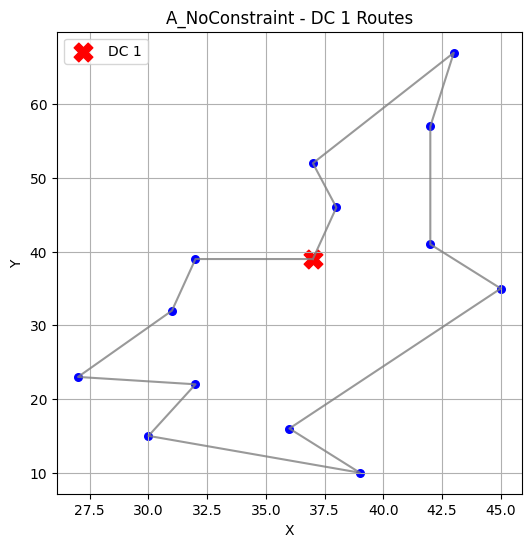

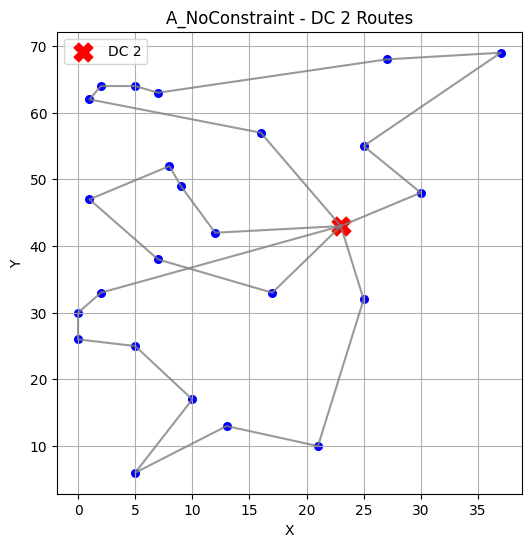

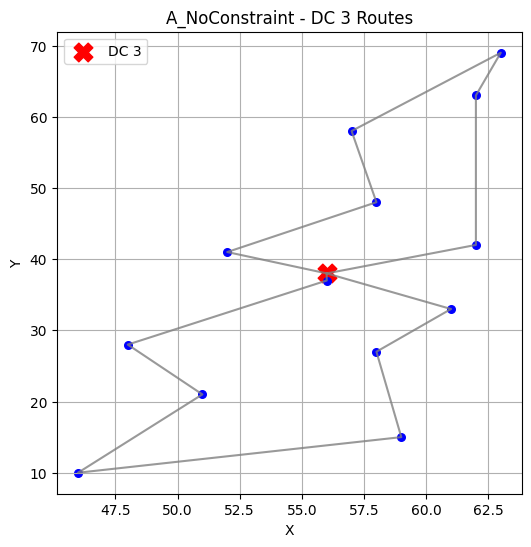


[B_LambdaOnly] MILP + VRP 풀이 시작
  λ = 0.45, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [1, 2, 3]
  DC 1 | VRP 거리 = 186.00, routes = [[0, 11, 2, 6, 7, 8, 1, 9, 0], [0, 3, 5, 10, 4, 15, 14, 13, 12, 17, 16, 0]]
  DC 2 | VRP 거리 = 234.83, routes = [[0, 11, 12, 18, 9, 3, 4, 8, 15, 0], [0, 13, 16, 20, 17, 0], [0, 1, 14, 6, 19, 2, 7, 5, 10, 0]]
  DC 3 | VRP 거리 = 143.58, routes = [[0, 4, 9, 10, 3, 5, 2, 0], [0, 8, 6, 11, 7, 1, 12, 13, 0]]

[B_LambdaOnly] 결과 요약
  개설된 DC: [1, 2, 3]
  개설비용: 120
  VRP 비용: 564.4069999999999
  총비용: 684.4069999999999


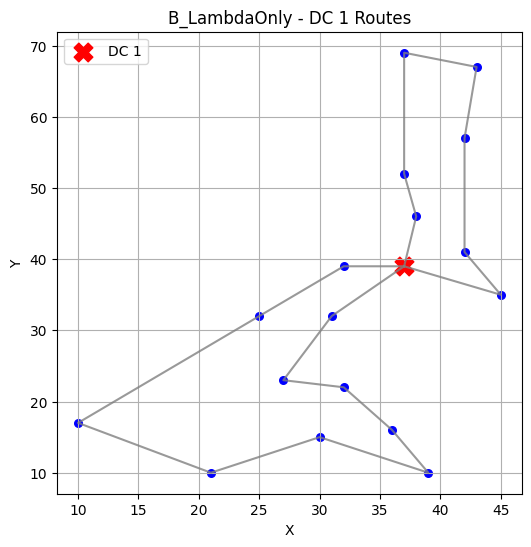

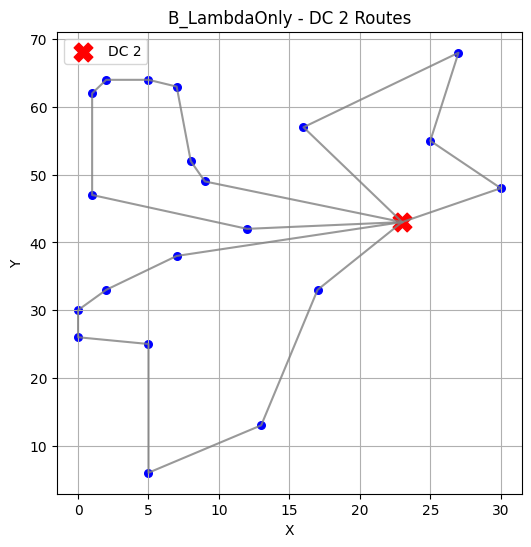

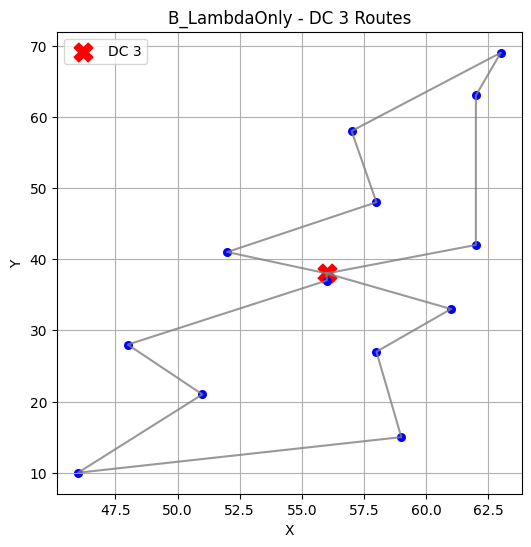


[C_MinCustOnly] MILP + VRP 풀이 시작
  λ = None, MIN_CUST = 20, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [2, 3]
  DC 2 | VRP 거리 = 321.36, routes = [[0, 28, 10, 13, 22, 27, 25, 15, 23, 24, 29, 0], [0, 30, 19, 21, 1, 20, 0], [0, 14, 11, 4, 5, 9, 18, 12, 0], [0, 16, 7, 26, 3, 8, 6, 17, 2, 0]]
  DC 3 | VRP 거리 = 196.73, routes = [[0, 20, 19, 1, 3, 18, 12, 17, 10, 13, 0], [0, 4, 16, 2, 11, 7, 8, 15, 14, 5, 9, 6, 0]]

[C_MinCustOnly] 결과 요약
  개설된 DC: [2, 3]
  개설비용: 80
  VRP 비용: 518.091
  총비용: 598.091


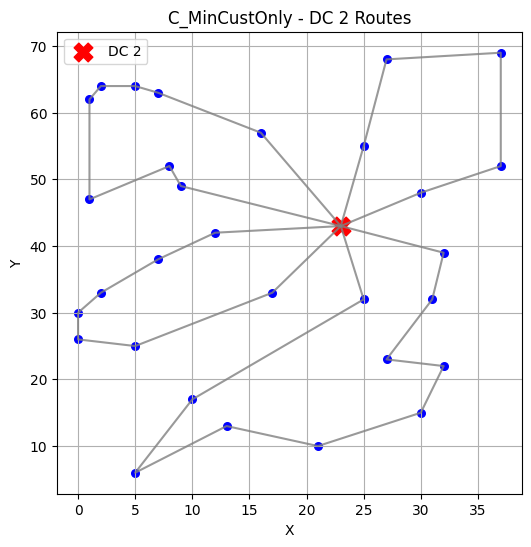

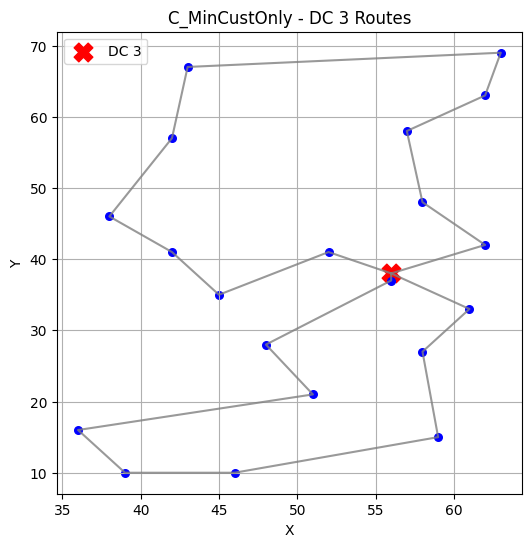


[D_LambdaPlusMinCust] MILP + VRP 풀이 시작
  λ = 0.45, MIN_CUST = 20, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.

================ 최종 비교 ================
A_None: total_cost=677.48, opened=[1, 2, 3]
B_LambdaOnly: total_cost=684.41, opened=[1, 2, 3]
C_MinCustOnly: total_cost=598.09, opened=[2, 3]
D_Both → infeasible or failed


In [1]:
# =========================================================
# Colab 버전 최종 코드
# - MILP: PuLP + CPLEX_PY (⚠ cplex 패키지 필수)
# - VRP: OR-Tools CVRP (트럭 용량 160 반영)
# - 케이스 A/B/C/D 4개 한 번에 실행
# =========================================================

!pip install pulp ortools cplex --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ---------------------------------------------
# 0) 데이터 로드
# ---------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc       = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck    = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수
D = len(dc)         # DC 수

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 예: 160
open_cost_j    = dc["COST"].values               # DC 개설비용
dc_capacity_j  = dc["CAPACITY"].values           # DC 보관용량

demand        = customer["DEMAND"].values
total_demand  = demand.sum()

cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]
dc_coords   = [(dc.loc[j, "X"],       dc.loc[j, "Y"])       for j in range(D)]

# ---------------------------------------------
# 1) 유틸 (거리)
# ---------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# ---------------------------------------------
# 2) OR-Tools VRP (트럭 용량 160 반영)
# ---------------------------------------------
def solve_vrp_ortools(demands, dist_matrix, vehicle_capacity, num_vehicles=None, time_limit_sec=10):
    """
    demands: [노드별 수요] (0번은 depot이므로 0)
    dist_matrix: NxN 거리행렬
    vehicle_capacity: 트럭 적재 용량 (여기서는 160)
    num_vehicles: None이면 충분히 많은 차량 허용 (3PL)
    """
    n_nodes = len(demands)
    if num_vehicles is None:
        num_vehicles = n_nodes - 1

    manager = pywrapcp.RoutingIndexManager(n_nodes, num_vehicles, 0)  # depot=0
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return int(dist_matrix[f][t] * 1000)  # 정수화

    transit_cb_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_index)

    def demand_callback(from_index):
        node = manager.IndexToNode(from_index)
        return int(demands[node])

    demand_cb_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_index,
        0,
        [vehicle_capacity] * num_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(time_limit_sec)

    solution = routing.SolveWithParameters(search_params)
    if not solution:
        return None, None

    routes = []
    total_cost = 0

    for v in range(num_vehicles):
        index = routing.Start(v)
        route = []
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            prev_index = index
            index = solution.Value(routing.NextVar(index))
            total_cost += routing.GetArcCostForVehicle(prev_index, index, v)
        node = manager.IndexToNode(index)
        route.append(node)
        if len(route) > 2:
            routes.append(route)

    total_cost = total_cost / 1000.0
    return total_cost, routes

# ---------------------------------------------
# 3) MILP 모델 생성 (제약 on/off 옵션)
# ---------------------------------------------
def build_milp_model(lam=None, min_cust=None, use_capacity=True):
    """
    lam      : 균형 제약 λ (None이면 미적용)
    min_cust : 최소 고객 수 (None이면 미적용)
    use_capacity : True면 DC CAPACITY 제약 적용
    """
    model = pulp.LpProblem("FacilityLocation_Generic", pulp.LpMinimize)

    # 변수
    y = pulp.LpVariable.dicts("OpenDC", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    # 거리 비용
    dist_cost = np.zeros((C, D))
    for i in range(C):
        for j in range(D):
            dist_cost[i, j] = euclid(cust_coords[i], dc_coords[j])

    # 목적함수: 개설비 + 배정 거리
    model += (
        pulp.lpSum([y[j] * open_cost_j[j] for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i, j] for i in range(C) for j in range(D)])
    )

    # (공통) 각 고객은 정확히 하나의 DC에 배정
    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    # (공통) DC가 열려야 배정 가능
    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    # (선택) 제약 1: 균형 제약 (λ)
    if lam is not None:
        max_load = lam * total_demand
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= max_load

    # (선택) 제약 2: 최소 고객 수 제약
    if min_cust is not None:
        for j in range(D):
            model += pulp.lpSum([x[i][j] for i in range(C)]) >= min_cust * y[j]

    # (선택) DC CAPACITY 제약
    if use_capacity:
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= dc_capacity_j[j]

    return model, x, y

# ---------------------------------------------
# 4) MILP + VRP 한 번에 푸는 함수 (CPLEX_PY 사용)
# ---------------------------------------------
def solve_milp_and_vrp(case_name, lam=None, min_cust=None,
                       use_capacity=True, vrp_time_limit=10, cplex_msg=False):
    print("\n============================")
    print(f"[{case_name}] MILP + VRP 풀이 시작")
    print(f"  λ = {lam}, MIN_CUST = {min_cust}, CAPACITY_CONSTR = {use_capacity}")
    print("============================")

    # 1) MILP 모델 생성
    model, x, y = build_milp_model(lam=lam, min_cust=min_cust, use_capacity=use_capacity)

    # 2) CPLEX_PY로 풀기 (⚠ cplex 모듈 필수)
    try:
        solver = pulp.CPLEX_PY(msg=cplex_msg)
    except Exception as e:
        raise RuntimeError("CPLEX_PY solver를 사용할 수 없습니다. Colab에서 'pip install cplex'가 성공했는지 확인하세요.") from e

    status = model.solve(solver)
    status_str = pulp.LpStatus[status]
    print("MILP Status:", status_str)
    if status_str != "Optimal":
        print(" → 최적해를 찾지 못했거나 infeasible 입니다.")
        return None

    # 3) MILP 결과 해석
    opened_centers = []
    assignment     = {}

    for j in range(D):
        if y[j].value() > 0.5:
            opened_centers.append(j)

    for i in range(C):
        for j in range(D):
            if x[i][j].value() > 0.5:
                assignment[i] = j
                break

    print("개설된 DC:", opened_centers)

    open_cost_total = sum(open_cost_j[j] for j in opened_centers)

    # 4) DC별 VRP (truck capacity 160 반영)
    total_vrp_cost = 0.0
    routes_detail  = {}

    for dc_id in opened_centers:
        cust_list = [i for i in range(C) if assignment[i] == dc_id]
        if not cust_list:
            continue

        # 0: depot, 1~k: 고객
        locs = []
        dc_row = dc.loc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))
        for cid in cust_list:
            crow = customer.loc[cid]
            locs.append((crow["X"], crow["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands = [0] + [int(demand[cid]) for cid in cust_list]

        vrp_dist, routes = solve_vrp_ortools(
            demands=demands,
            dist_matrix=dist_matrix,
            vehicle_capacity=TRUCK_CAPACITY,
            num_vehicles=None,
            time_limit_sec=vrp_time_limit
        )

        if vrp_dist is None:
            print(f"  DC {dc_id} VRP 풀이 실패 (infeasible)")
            return None

        total_vrp_cost += vrp_dist
        routes_detail[dc_id] = {
            "routes": routes,
            "locs":  locs,
            "customers": cust_list
        }

        print(f"  DC {dc_id} | VRP 거리 = {vrp_dist:.2f}, routes = {routes}")

    total_cost = open_cost_total + total_vrp_cost

    print(f"\n[{case_name}] 결과 요약")
    print("  개설된 DC:", opened_centers)
    print("  개설비용:", open_cost_total)
    print("  VRP 비용:", total_vrp_cost)
    print("  총비용:", total_cost)

    # 5) 시각화 (DC별)
    for dc_id in opened_centers:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]

        plt.figure(figsize=(6,6))
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        for route in routes:
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)
                if node != 0:
                    plt.scatter(x, y, c="blue", s=30)
            plt.plot(xs, ys, c="gray", alpha=0.8)

        plt.title(f"{case_name} - DC {dc_id} Routes")
        plt.xlabel("X"); plt.ylabel("Y")
        plt.grid(True); plt.legend()
        plt.show()

    result = {
        "case": case_name,
        "lambda": lam,
        "min_cust": min_cust,
        "opened": opened_centers,
        "open_cost": open_cost_total,
        "vrp_cost": total_vrp_cost,
        "total_cost": total_cost,
        "routes_detail": routes_detail,
        "assignment": assignment
    }
    return result

# ---------------------------------------------
# 5) 4가지 케이스 한 번에 실행
#    (λ, MIN_CUST 값은 필요에 따라 수정 가능)
# ---------------------------------------------
results_all = {}

# A. 제약 없음
results_all["A_None"] = solve_milp_and_vrp(
    case_name="A_NoConstraint",
    lam=None,
    min_cust=None,
    use_capacity=True,
    vrp_time_limit=10
)

# B. 제약 1만 (λ)
results_all["B_LambdaOnly"] = solve_milp_and_vrp(
    case_name="B_LambdaOnly",
    lam=0.45,       # 공주님이 원하는 λ 값으로 수정 가능
    min_cust=None,
    use_capacity=True,
    vrp_time_limit=10
)

# C. 제약 2만 (MIN_CUST)
results_all["C_MinCustOnly"] = solve_milp_and_vrp(
    case_name="C_MinCustOnly",
    lam=None,
    min_cust=20,    # 공주님이 실험하고 싶은 값
    use_capacity=True,
    vrp_time_limit=10
)

# D. 제약 1+2 동시 적용
results_all["D_Both"] = solve_milp_and_vrp(
    case_name="D_LambdaPlusMinCust",
    lam=0.45,
    min_cust=20,
    use_capacity=True,
    vrp_time_limit=10
)

print("\n================ 최종 비교 ================")
for k, res in results_all.items():
    if res is None:
        print(k, "→ infeasible or failed")
    else:
        print(f"{k}: total_cost={res['total_cost']:.2f}, opened={res['opened']}")
print("==========================================")


[A_NoConstraint] MILP + VRP 풀이 시작
  λ = None, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [1, 2, 3]
  DC 1 | VRP 거리 = 134.39, routes = [[0, 13, 3, 5, 9, 11, 12, 4, 10, 2, 6, 7, 1, 8, 0]]
  DC 2 | VRP 거리 = 279.52, routes = [[0, 11, 15, 5, 14, 1, 10, 0], [0, 13, 7, 2, 22, 6, 16, 18, 24, 17, 0], [0, 23, 21, 12, 19, 20, 9, 3, 4, 8, 0]]
  DC 3 | VRP 거리 = 143.58, routes = [[0, 4, 9, 10, 3, 5, 2, 0], [0, 8, 6, 11, 7, 1, 12, 13, 0]]

[A_NoConstraint] 결과 요약
  개설된 DC: [1, 2, 3]
  개설비용: 120
  VRP 비용: 557.482
  총비용: 677.482


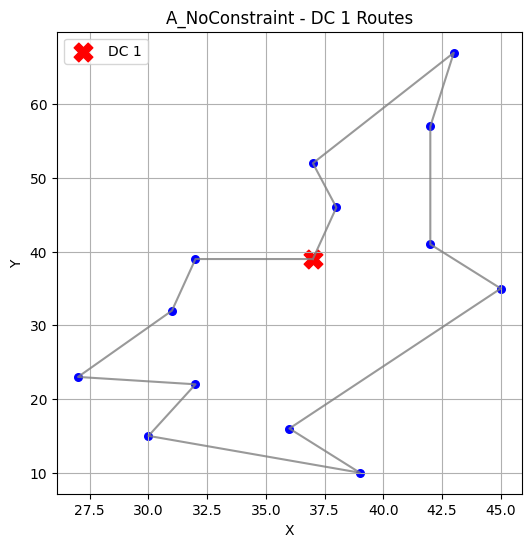

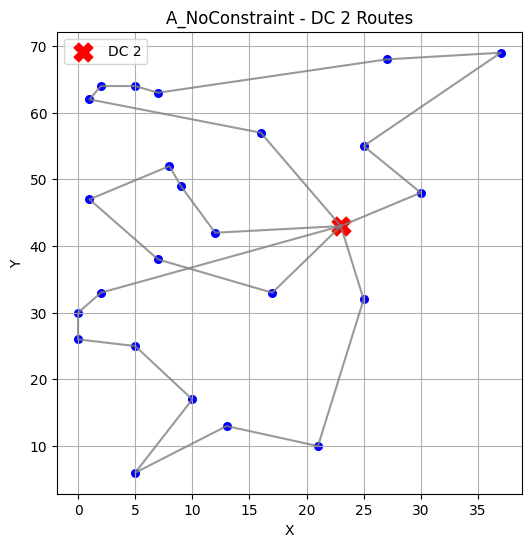

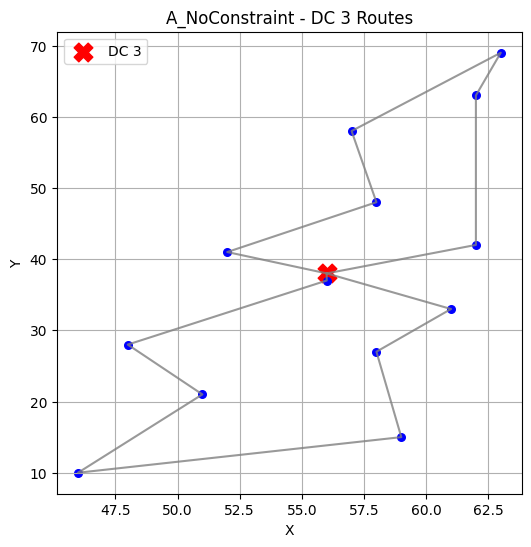


=== B_LambdaOnly — λ grid search ===

[B_LambdaOnly_lam0.1] MILP + VRP 풀이 시작
  λ = 0.1, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.10 → infeasible

[B_LambdaOnly_lam0.15] MILP + VRP 풀이 시작
  λ = 0.15, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.15 → infeasible

[B_LambdaOnly_lam0.2] MILP + VRP 풀이 시작
  λ = 0.2, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.20 → infeasible

[B_LambdaOnly_lam0.25] MILP + VRP 풀이 시작
  λ = 0.25, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [0, 1, 2, 3, 4]
  DC 0 | VRP 거리 = 127.49, routes = [[0, 7, 0], [0, 4, 2, 9, 3, 5, 10, 6, 8, 1, 0]]
  DC 1 | VRP 거리 = 137.80, routes = [[0, 1, 0], [0, 5, 2, 4, 9, 8, 7, 6, 3, 11, 10, 0]]
  DC 2 | VRP 거리 = 168.98, routes = [[0, 4, 5, 1, 10, 0], [0, 9, 12, 7, 2, 3, 6, 11, 8, 0]]
  DC 3 | VRP 거리 = 127.57, routes = [[0, 4, 8, 9, 3, 5,

In [ ]:
# =========================================================
# Colab 버전 최종 코드 (튜닝 버전)
# - MILP: PuLP + CPLEX_PY (⚠ cplex 패키지 필수)
# - VRP: OR-Tools CVRP (트럭 용량 160 반영)
# - 케이스 A/B/C/D 4개 한 번에 실행
#   * B: λ 자동 탐색
#   * C: min_cust 자동 탐색
#   * D: (λ, min_cust) 그리드 서치
# =========================================================

!pip install pulp ortools cplex --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ---------------------------------------------
# 0) 데이터 로드
# ---------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc       = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck    = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수
D = len(dc)         # DC 수

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 예: 160
open_cost_j    = dc["COST"].values               # DC 개설비용
dc_capacity_j  = dc["CAPACITY"].values           # DC 보관용량

demand        = customer["DEMAND"].values
total_demand  = demand.sum()

cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]
dc_coords   = [(dc.loc[j, "X"],       dc.loc[j, "Y"])       for j in range(D)]

# ---------------------------------------------
# 1) 유틸 (거리)
# ---------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# ---------------------------------------------
# 2) OR-Tools VRP (트럭 용량 160 반영)
# ---------------------------------------------
def solve_vrp_ortools(demands, dist_matrix, vehicle_capacity, num_vehicles=None, time_limit_sec=10):
    """
    demands: [노드별 수요] (0번은 depot이므로 0)
    dist_matrix: NxN 거리행렬
    vehicle_capacity: 트럭 적재 용량 (여기서는 160)
    num_vehicles: None이면 충분히 많은 차량 허용 (3PL)
    """
    n_nodes = len(demands)
    if num_vehicles is None:
        num_vehicles = n_nodes - 1

    manager = pywrapcp.RoutingIndexManager(n_nodes, num_vehicles, 0)  # depot=0
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return int(dist_matrix[f][t] * 1000)  # 정수화

    transit_cb_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_index)

    def demand_callback(from_index):
        node = manager.IndexToNode(from_index)
        return int(demands[node])

    demand_cb_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_index,
        0,
        [vehicle_capacity] * num_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(time_limit_sec)

    solution = routing.SolveWithParameters(search_params)
    if not solution:
        return None, None

    routes = []
    total_cost = 0

    for v in range(num_vehicles):
        index = routing.Start(v)
        route = []
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            prev_index = index
            index = solution.Value(routing.NextVar(index))
            total_cost += routing.GetArcCostForVehicle(prev_index, index, v)
        node = manager.IndexToNode(index)
        route.append(node)
        if len(route) > 2:
            routes.append(route)

    total_cost = total_cost / 1000.0
    return total_cost, routes

# ---------------------------------------------
# 3) MILP 모델 생성 (제약 on/off 옵션)
# ---------------------------------------------
def build_milp_model(lam=None, min_cust=None, use_capacity=True):
    """
    lam      : 균형 제약 λ (None이면 미적용)
    min_cust : 최소 고객 수 (None이면 미적용)
    use_capacity : True면 DC CAPACITY 제약 적용
    """
    model = pulp.LpProblem("FacilityLocation_Generic", pulp.LpMinimize)

    # 변수
    y = pulp.LpVariable.dicts("OpenDC", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    # 거리 비용
    dist_cost = np.zeros((C, D))
    for i in range(C):
        for j in range(D):
            dist_cost[i, j] = euclid(cust_coords[i], dc_coords[j])

    # 목적함수: 개설비 + 배정 거리
    model += (
        pulp.lpSum([y[j] * open_cost_j[j] for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i, j] for i in range(C) for j in range(D)])
    )

    # (공통) 각 고객은 정확히 하나의 DC에 배정
    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    # (공통) DC가 열려야 배정 가능
    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    # (선택) 제약 1: 균형 제약 (λ)  → 각 DC가 담당하는 총 수요 상한
    if lam is not None:
        max_load = lam * total_demand
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= max_load

    # (선택) 제약 2: 최소 고객 수 제약
    if min_cust is not None:
        for j in range(D):
            model += pulp.lpSum([x[i][j] for i in range(C)]) >= min_cust * y[j]

    # (선택) DC CAPACITY 제약
    if use_capacity:
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= dc_capacity_j[j]

    return model, x, y

# ---------------------------------------------
# 4) MILP + VRP 한 번에 푸는 함수 (CPLEX_PY 사용)
# ---------------------------------------------
def solve_milp_and_vrp(case_name, lam=None, min_cust=None,
                       use_capacity=True, vrp_time_limit=10,
                       cplex_msg=False, do_plot=False):
    print("\n============================")
    print(f"[{case_name}] MILP + VRP 풀이 시작")
    print(f"  λ = {lam}, MIN_CUST = {min_cust}, CAPACITY_CONSTR = {use_capacity}")
    print("============================")

    # 1) MILP 모델 생성
    model, x, y = build_milp_model(lam=lam, min_cust=min_cust, use_capacity=use_capacity)

    # 2) CPLEX_PY로 풀기
    try:
        solver = pulp.CPLEX_PY(msg=cplex_msg)
    except Exception as e:
        raise RuntimeError("CPLEX_PY solver를 사용할 수 없습니다. Colab에서 'pip install cplex'가 성공했는지 확인하세요.") from e

    status = model.solve(solver)
    status_str = pulp.LpStatus[status]
    print("MILP Status:", status_str)
    if status_str != "Optimal":
        print(" → 최적해를 찾지 못했거나 infeasible 입니다.")
        return None

    # 3) MILP 결과 해석
    opened_centers = []
    assignment     = {}

    for j in range(D):
        if y[j].value() > 0.5:
            opened_centers.append(j)

    for i in range(C):
        for j in range(D):
            if x[i][j].value() > 0.5:
                assignment[i] = j
                break

    if len(opened_centers) == 0:
        print(" → 어떤 DC도 열리지 않음 (infeasible 취급)")
        return None

    print("개설된 DC:", opened_centers)

    open_cost_total = sum(open_cost_j[j] for j in opened_centers)

    # 4) DC별 VRP (truck capacity 160 반영)
    total_vrp_cost = 0.0
    routes_detail  = {}

    for dc_id in opened_centers:
        cust_list = [i for i in range(C) if assignment[i] == dc_id]
        if not cust_list:
            continue

        # 0: depot, 1~k: 고객
        locs = []
        dc_row = dc.loc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))
        for cid in cust_list:
            crow = customer.loc[cid]
            locs.append((crow["X"], crow["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands = [0] + [int(demand[cid]) for cid in cust_list]

        vrp_dist, routes = solve_vrp_ortools(
            demands=demands,
            dist_matrix=dist_matrix,
            vehicle_capacity=TRUCK_CAPACITY,
            num_vehicles=None,
            time_limit_sec=vrp_time_limit
        )

        if vrp_dist is None:
            print(f"  DC {dc_id} VRP 풀이 실패 (infeasible)")
            return None

        total_vrp_cost += vrp_dist
        routes_detail[dc_id] = {
            "routes": routes,
            "locs":  locs,
            "customers": cust_list
        }

        print(f"  DC {dc_id} | VRP 거리 = {vrp_dist:.2f}, routes = {routes}")

    total_cost = open_cost_total + total_vrp_cost

    print(f"\n[{case_name}] 결과 요약")
    print("  개설된 DC:", opened_centers)
    print("  개설비용:", open_cost_total)
    print("  VRP 비용:", total_vrp_cost)
    print("  총비용:", total_cost)

    # 5) 시각화 (옵션)
    if do_plot:
        for dc_id in opened_centers:
            detail = routes_detail[dc_id]
            routes = detail["routes"]
            locs   = detail["locs"]

            plt.figure(figsize=(6,6))
            x_dc, y_dc = locs[0]
            plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

            for route in routes:
                xs, ys = [], []
                for node in route:
                    x, y = locs[node]
                    xs.append(x); ys.append(y)
                    if node != 0:
                        plt.scatter(x, y, c="blue", s=30)
                plt.plot(xs, ys, c="gray", alpha=0.8)

            plt.title(f"{case_name} - DC {dc_id} Routes")
            plt.xlabel("X"); plt.ylabel("Y")
            plt.grid(True); plt.legend()
            plt.show()

    result = {
        "case": case_name,
        "lambda": lam,
        "min_cust": min_cust,
        "opened": opened_centers,
        "open_cost": open_cost_total,
        "vrp_cost": total_vrp_cost,
        "total_cost": total_cost,
        "routes_detail": routes_detail,
        "assignment": assignment
    }
    return result

# ---------------------------------------------
# 5) λ / min_cust 후보 자동 생성
# ---------------------------------------------
def lambda_candidates():
    # 0.10 ~ 0.90, 0.05 간격 (필요하면 간격 더 촘촘하게 조절 가능)
    return [round(0.10 + 0.05 * k, 2) for k in range(0, 17)]

def min_cust_candidates():
    # 고객 수 C 기준으로 합리적인 후보 생성 (예: 50명이면 5,10,15,20,25)
    step = max(1, C // 10)
    max_val = max(step, C // 2)
    return list(range(step, max_val + 1, step))

# ---------------------------------------------
# 6) 4가지 케이스 한 번에 실행 (튜닝 포함)
# ---------------------------------------------
results_all = {}

# A. 제약 없음 (한 번만, 플롯도 켜 둠)
results_all["A_None"] = solve_milp_and_vrp(
    case_name="A_NoConstraint",
    lam=None,
    min_cust=None,
    use_capacity=True,
    vrp_time_limit=10,
    do_plot=True
)

# B. 제약 1만 (λ)  → 여러 λ 중 최적 λ 찾기
print("\n=== B_LambdaOnly — λ grid search ===")
best_B = None
for lam in lambda_candidates():
    res = solve_milp_and_vrp(
        case_name=f"B_LambdaOnly_lam{lam}",
        lam=lam,
        min_cust=None,
        use_capacity=True,
        vrp_time_limit=5,
        do_plot=False
    )
    if res is None:
        print(f"  λ={lam:.2f} → infeasible")
        continue
    print(f"  λ={lam:.2f} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_B is None) or (res["total_cost"] < best_B["total_cost"]):
        best_B = res
results_all["B_LambdaOnly"] = best_B

# C. 제약 2만 (MIN_CUST) → 여러 min_cust 중 최적 찾기
print("\n=== C_MinCustOnly — min_cust grid search ===")
best_C = None
for mc in min_cust_candidates():
    res = solve_milp_and_vrp(
        case_name=f"C_MinCustOnly_mc{mc}",
        lam=None,
        min_cust=mc,
        use_capacity=True,
        vrp_time_limit=5,
        do_plot=False
    )
    if res is None:
        print(f"  min_cust={mc} → infeasible")
        continue
    print(f"  min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_C is None) or (res["total_cost"] < best_C["total_cost"]):
        best_C = res
results_all["C_MinCustOnly"] = best_C

# D. 제약 1+2 동시 적용 → (λ, min_cust) 조합 전부 탐색
print("\n=== D_Both — (λ, min_cust) grid search ===")
best_D = None
for lam in lambda_candidates():
    for mc in min_cust_candidates():
        res = solve_milp_and_vrp(
            case_name=f"D_Both_lam{lam}_mc{mc}",
            lam=lam,
            min_cust=mc,
            use_capacity=True,
            vrp_time_limit=5,
            do_plot=False
        )
        if res is None:
            print(f"  λ={lam:.2f}, min_cust={mc} → infeasible")
            continue
        print(f"  λ={lam:.2f}, min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
        if (best_D is None) or (res["total_cost"] < best_D["total_cost"]):
            best_D = res
results_all["D_Both"] = best_D

# ---------------------------------------------
# 7) 최종 비교 출력
# ---------------------------------------------
print("\n================ 최종 비교 ================")
for k, res in results_all.items():
    if res is None:
        print(k, "→ infeasible or failed")
    else:
        print(
            f"{k}: TOTAL={res['total_cost']:.2f}, opened={res['opened']}, "
            f"λ={res['lambda']}, min_cust={res['min_cust']}"
        )
print("==========================================")
